# Lab 9 - Detección de Anomalías con Autoencoder, Isolation Forest y LOF

In [1]:
#!pip install -r requirements

In [2]:
from sklearn.datasets import fetch_covtype
import numpy as np 
import pandas as pd


In [3]:
bunch = fetch_covtype(as_frame=True)

X: pd.DataFrame = bunch.data 
y: pd.Series = bunch.target

df = X.copy()
df['Cover_Type'] = y
print(X.shape, y.shape)

(581012, 54) (581012,)


In [4]:
type(df)

pandas.core.frame.DataFrame

In [5]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


### Standardization and Train/Test/Val

In [6]:
y_bin = (y!=2).astype(int)
X_normal = X[y_bin == 0]
X_anomal = X[y_bin == 1]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


test_normals = X_normal.sample(frac=0.2, random_state=32)
test_anoms   = X_anomal.sample(frac=0.2, random_state=32)

X_test = pd.concat([test_normals, test_anoms]).sample(frac=1, random_state=32)

y_test = pd.Series(0, index=X_test.index)
y_test.loc[X_test.index.intersection(X_anomal.index)] = 1  # anomalies = 1

X_normal_remaining = X_normal.drop(test_normals.index) # drop samples from remaining on testing.
X_train, X_val = train_test_split(X_normal_remaining, test_size=0.25, random_state=32, shuffle=True) 


In [8]:



binary_cols = [c for c in X_train.columns if set(X[c].unique()).issubset({0, 1})]
cols_to_scale = [c for c in X_train.columns if c not in binary_cols]

scaler = StandardScaler().fit(X_train[cols_to_scale])

def apply_scaler(df: pd.DataFrame) -> pd.DataFrame:
    df_scaled = df.copy()
    df_scaled[cols_to_scale] = scaler.transform(df[cols_to_scale])
    return df_scaled
X_train_s = X_train.copy()
X_train_s = apply_scaler(X_train)
X_val_s   = X_val.copy()
X_val_s   = apply_scaler(X_val)
X_test_s  = X_test.copy()
X_test_s  = apply_scaler(X_test)

In [9]:

anoms_rem = X_anomal.drop(test_anoms.index)
val_anoms = anoms_rem.sample(frac=0.2, random_state=32)

val_norms = X_val.sample(n=min(len(X_val), len(val_anoms)), random_state=32)

X_val_mixed  = pd.concat([val_norms, val_anoms]).sample(frac=1, random_state=32)
y_val_mixed  = pd.Series(0, index=X_val_mixed.index)
y_val_mixed.loc[X_val_mixed.index.intersection(X_anomal.index)] = 1

X_val_mixed_s = apply_scaler(X_val_mixed)


In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, confusion_matrix

In [30]:
def pr_auc(y_true, scores):
    return average_precision_score(y_true, scores)

def roc_auc(y_true, scores):
    return roc_auc_score(y_true, scores)

def best_f1_threshold(y_true, scores):
    ps, rs, ts = precision_recall_curve(y_true, scores)
    # Ignora el último umbral (nan)
    ts = ts if len(ts)==len(ps)-1 else ts[:len(ps)-1]
    f1s = (2*ps[:-1]*rs[:-1]/(ps[:-1]+rs[:-1]+1e-12))
    i = np.nanargmax(f1s)
    return float(ts[i]), float(f1s[i]), float(ps[i]), float(rs[i])

def percentile_threshold(scores, q=0.99):
    return float(np.quantile(scores, q))

def precision_at_k(y_true, scores, k=0.01):
    n = max(1, int(len(scores)*k))
    idx = np.argsort(scores)[::-1][:n]
    return float(np.mean(np.array(y_true)[idx]))

In [31]:
def eval_binary(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return {
        "ROC-AUC": roc_auc_score(y_true, scores),
        "PR-AUC":  average_precision_score(y_true, scores),
        "F1@thr":  f1_score(y_true, y_pred),
        "P@1%":    precision_at_k(y_true, scores, 0.01),
        "ConfMat": cm
    }

# Autoencoder

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [14]:
input_dim = X_train_s.shape[1]
enc_dim = 32

ae = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(enc_dim, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(input_dim, activation=None),
])

ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

es = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

hist = ae.fit(
    X_train_s, X_train_s,
    validation_data=(X_val_s, X_val_s),
    epochs=200, batch_size=256, callbacks=[es], verbose=0
)

# Scores = error de reconstrucción (mayor = más anómalo)
val_err  = np.mean(np.square(X_val_s - ae.predict(X_val_s, verbose=0)), axis=1)
test_err = np.mean(np.square(X_test_s - ae.predict(X_test_s, verbose=0)), axis=1)

In [15]:
valmix_err = np.mean(np.square(X_val_mixed_s - ae.predict(X_val_mixed_s, verbose=0)), axis=1)
thr_ae_f1, f1_v, p_v, r_v = best_f1_threshold(y_val_mixed, valmix_err)
y_pred_f1 = (test_err >= thr_ae_f1).astype(int)
res_ae_f1 = eval_binary(y_test, test_err, thr_ae_f1)
res_ae_f1, thr_ae_f1


({'ROC-AUC': 0.721734319530956,
  'PR-AUC': 0.7667441335253011,
  'F1@thr': 0.6875636306680242,
  'P@1%': 1.0,
  'ConfMat': array([[15651, 41009],
         [ 6865, 52677]])},
 1.2106140322461418e-05)

# Análisis del problema actual del umbral

Umbral actual F1: 1.21e-05
Matriz de confusión actual:
TN: 15651, FP: 41009
FN: 6865, TP: 52677

Estadísticas de errores de reconstrucción:
Normales - Media: 2.81e-05, Mediana: 1.48e-05
Normales - P95: 4.92e-05, P99: 1.42e-04
Normales - P99.9: 8.89e-04

Anomalías - Media: 1.44e-03, Mediana: 2.43e-05
Anomalías - P5: 1.03e-05, P1: 8.78e-06


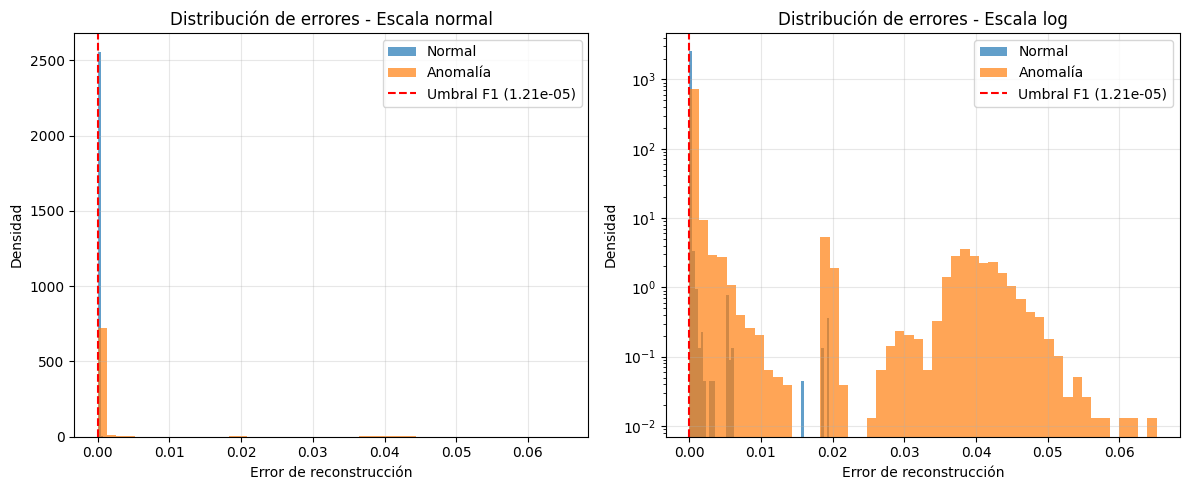

In [16]:
# Análisis del problema actual
print(f"Umbral actual F1: {thr_ae_f1:.2e}")
print(f"Matriz de confusión actual:")
cm_current = confusion_matrix(y_test, (test_err >= thr_ae_f1).astype(int))
print(f"TN: {cm_current[0,0]}, FP: {cm_current[0,1]}")
print(f"FN: {cm_current[1,0]}, TP: {cm_current[1,1]}")
print()

# Estadísticas de errores por clase
test_err_normal = test_err[y_test == 0]
test_err_anomal = test_err[y_test == 1]

print("Estadísticas de errores de reconstrucción:")
print(f"Normales - Media: {test_err_normal.mean():.2e}, Mediana: {np.median(test_err_normal):.2e}")
print(f"Normales - P95: {np.percentile(test_err_normal, 95):.2e}, P99: {np.percentile(test_err_normal, 99):.2e}")
print(f"Normales - P99.9: {np.percentile(test_err_normal, 99.9):.2e}")
print()
print(f"Anomalías - Media: {test_err_anomal.mean():.2e}, Mediana: {np.median(test_err_anomal):.2e}")
print(f"Anomalías - P5: {np.percentile(test_err_anomal, 5):.2e}, P1: {np.percentile(test_err_anomal, 1):.2e}")

# Visualización del problema
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_err_normal, bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(test_err_anomal, bins=50, alpha=0.7, label='Anomalía', density=True)
plt.axvline(thr_ae_f1, color='red', linestyle='--', label=f'Umbral F1 ({thr_ae_f1:.2e})')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Densidad')
plt.title('Distribución de errores - Escala normal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_err_normal, bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(test_err_anomal, bins=50, alpha=0.7, label='Anomalía', density=True)
plt.axvline(thr_ae_f1, color='red', linestyle='--', label=f'Umbral F1 ({thr_ae_f1:.2e})')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Densidad')
plt.title('Distribución de errores - Escala log')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Nuevas estrategias de umbralizacion

In [17]:
def best_f1_with_min_precision(y_true, scores, min_precision=0.85):
    """
    Encuentra el mejor F1 con restricción de precisión mínima.
    """
    ps, rs, ts = precision_recall_curve(y_true, scores)
    ts = ts if len(ts)==len(ps)-1 else ts[:len(ps)-1]
    f1s = (2*ps[:-1]*rs[:-1]/(ps[:-1]+rs[:-1]+1e-12))
    
    # Filtrar por precisión mínima
    valid_indices = ps[:-1] >= min_precision
    
    if not np.any(valid_indices):
        print(f"Warning: No se encontró ningún umbral con precisión >= {min_precision}")
        # Devolver el de mayor precisión disponible
        i = np.nanargmax(ps[:-1])
        return float(ts[i]), float(f1s[i]), float(ps[i]), float(rs[i])
    
    # De los válidos, elegir el de mejor F1
    valid_f1s = f1s[valid_indices]
    valid_ps = ps[:-1][valid_indices]
    valid_rs = rs[:-1][valid_indices]
    valid_ts = ts[valid_indices]
    
    best_idx = np.nanargmax(valid_f1s)
    
    return (float(valid_ts[best_idx]), float(valid_f1s[best_idx]), 
            float(valid_ps[best_idx]), float(valid_rs[best_idx]))

def create_imbalanced_validation(X_normal_remaining, X_anomal_remaining, anomaly_rate=0.05, random_state=32):
    """
    Crea un conjunto de validación desbalanceado que refleja la prevalencia real.
    """
    # Calcular tamaños
    n_val_total = len(X_normal_remaining) // 4  # 25% del total disponible
    n_val_anomalies = max(1, int(n_val_total * anomaly_rate))
    n_val_normals = n_val_total - n_val_anomalies
    
    # Asegurar que tenemos suficientes muestras
    n_val_normals = min(n_val_normals, len(X_normal_remaining))
    n_val_anomalies = min(n_val_anomalies, len(X_anomal_remaining))
    
    print(f"Validación desbalanceada: {n_val_normals} normales + {n_val_anomalies} anomalías")
    print(f"Tasa real de anomalías: {n_val_anomalies/(n_val_normals+n_val_anomalies):.3f}")
    
    # Muestrear
    val_normals_imb = X_normal_remaining.sample(n=n_val_normals, random_state=random_state)
    val_anomalies_imb = X_anomal_remaining.sample(n=n_val_anomalies, random_state=random_state)
    
    # Combinar
    X_val_imbalanced = pd.concat([val_normals_imb, val_anomalies_imb]).sample(frac=1, random_state=random_state)
    y_val_imbalanced = pd.Series(0, index=X_val_imbalanced.index)
    y_val_imbalanced.loc[X_val_imbalanced.index.intersection(X_anomal_remaining.index)] = 1
    
    return X_val_imbalanced, y_val_imbalanced

# Aplicar nuevas estrategias
print("=== ESTRATEGIA 1: Percentiles altos en validación solo normales ===")
val_err_normals_only = val_err  # val_err ya es solo de normales

thr_p999 = np.percentile(val_err_normals_only, 99.9)
thr_p9995 = np.percentile(val_err_normals_only, 99.95)
thr_p99 = np.percentile(val_err_normals_only, 99.0)

print(f"Umbral P99.0: {thr_p99:.2e}")
print(f"Umbral P99.9: {thr_p999:.2e}")
print(f"Umbral P99.95: {thr_p9995:.2e}")

# Evaluar en test
res_p99 = eval_binary(y_test, test_err, thr_p99)
res_p999 = eval_binary(y_test, test_err, thr_p999)
res_p9995 = eval_binary(y_test, test_err, thr_p9995)

print(f"\\nResultados P99.0: {res_p99}")
print(f"Resultados P99.9: {res_p999}")
print(f"Resultados P99.95: {res_p9995}")

print("\\n=== ESTRATEGIA 2: Mejor F1 con restricción de precisión ===")
thr_f1_p85, f1_p85, p_p85, r_p85 = best_f1_with_min_precision(y_val_mixed, valmix_err, min_precision=0.85)
thr_f1_p90, f1_p90, p_p90, r_p90 = best_f1_with_min_precision(y_val_mixed, valmix_err, min_precision=0.90)

print(f"Umbral F1 con P>=0.85: {thr_f1_p85:.2e} (F1: {f1_p85:.3f}, P: {p_p85:.3f}, R: {r_p85:.3f})")
print(f"Umbral F1 con P>=0.90: {thr_f1_p90:.2e} (F1: {f1_p90:.3f}, P: {p_p90:.3f}, R: {r_p90:.3f})")

res_f1_p85 = eval_binary(y_test, test_err, thr_f1_p85)
res_f1_p90 = eval_binary(y_test, test_err, thr_f1_p90)

print(f"\\nResultados F1 P>=0.85: {res_f1_p85}")
print(f"Resultados F1 P>=0.90: {res_f1_p90}")

=== ESTRATEGIA 1: Percentiles altos en validación solo normales ===
Umbral P99.0: 1.50e-04
Umbral P99.9: 9.84e-04
Umbral P99.95: 5.37e-03
\nResultados P99.0: {'ROC-AUC': 0.721734319530956, 'PR-AUC': 0.7667441335253011, 'F1@thr': 0.3167465187302121, 'P@1%': 1.0, 'ConfMat': array([[56125,   535],
       [48237, 11305]])}
Resultados P99.9: {'ROC-AUC': 0.721734319530956, 'PR-AUC': 0.7667441335253011, 'F1@thr': 0.12782935142861632, 'P@1%': 1.0, 'ConfMat': array([[56608,    52],
       [55473,  4069]])}
Resultados P99.95: {'ROC-AUC': 0.721734319530956, 'PR-AUC': 0.7667441335253011, 'F1@thr': 0.07571793132409471, 'P@1%': 1.0, 'ConfMat': array([[56632,    28],
       [57198,  2344]])}
\n=== ESTRATEGIA 2: Mejor F1 con restricción de precisión ===
Umbral F1 con P>=0.85: 4.29e-05 (F1: 0.512, P: 0.850, R: 0.366)
Umbral F1 con P>=0.90: 7.11e-05 (F1: 0.417, P: 0.900, R: 0.271)
\nResultados F1 P>=0.85: {'ROC-AUC': 0.721734319530956, 'PR-AUC': 0.7667441335253011, 'F1@thr': 0.5127920960173548, 'P@1%': 

In [18]:
print("\n=== ESTRATEGIA 3: Validación desbalanceada que refleja prevalencia real ===")

# Necesitamos los anomalías restantes para crear validación desbalanceada
anoms_for_val = anoms_rem.drop(val_anoms.index) if 'val_anoms' in globals() else anoms_rem

# Crear validación desbalanceada (5% anomalías - más realista)
X_val_imb, y_val_imb = create_imbalanced_validation(
    X_normal_remaining.drop(X_val.index), 
    anoms_for_val, 
    anomaly_rate=0.05, 
    random_state=32
)

# Escalar
X_val_imb_s = apply_scaler(X_val_imb)

# Obtener errores de validación desbalanceada
valmix_imb_err = np.mean(np.square(X_val_imb_s - ae.predict(X_val_imb_s, verbose=0)), axis=1)

# Estrategias con validación desbalanceada
thr_imb_f1, f1_imb, p_imb, r_imb = best_f1_threshold(y_val_imb, valmix_imb_err)
thr_imb_f1_p85, f1_imb_p85, p_imb_p85, r_imb_p85 = best_f1_with_min_precision(y_val_imb, valmix_imb_err, min_precision=0.85)

print(f"Umbral F1 desbalanceado: {thr_imb_f1:.2e} (F1: {f1_imb:.3f}, P: {p_imb:.3f}, R: {r_imb:.3f})")
print(f"Umbral F1 desbalanceado P>=0.85: {thr_imb_f1_p85:.2e} (F1: {f1_imb_p85:.3f}, P: {p_imb_p85:.3f}, R: {r_imb_p85:.3f})")

res_imb_f1 = eval_binary(y_test, test_err, thr_imb_f1)
res_imb_f1_p85 = eval_binary(y_test, test_err, thr_imb_f1_p85)

print(f"\nResultados F1 desbalanceado: {res_imb_f1}")
print(f"Resultados F1 desbal. P>=0.85: {res_imb_f1_p85}")

# Resumen comparativo de todas las estrategias
print("\n=== RESUMEN COMPARATIVO ===")
strategies = {
    'Original F1 (bal.)': (thr_ae_f1, res_ae_f1),
    'Percentil 99.0%': (thr_p99, res_p99),
    'Percentil 99.9%': (thr_p999, res_p999),
    'F1 con P>=0.85': (thr_f1_p85, res_f1_p85),
    'F1 con P>=0.90': (thr_f1_p90, res_f1_p90),
    'F1 desbalanceado': (thr_imb_f1, res_imb_f1),
    'F1 desbal. P>=0.85': (thr_imb_f1_p85, res_imb_f1_p85),
}

print(f"{'Estrategia':<20} {'Umbral':<12} {'F1':<8} {'Precisión':<10} {'ROC-AUC':<8}")
print("-" * 65)
for name, (thr, res) in strategies.items():
    precision = res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0
    print(f"{name:<20} {thr:<12.2e} {res['F1@thr']:<8.3f} {precision:<10.3f} {res['ROC-AUC']:<8.3f}")


=== ESTRATEGIA 3: Validación desbalanceada que refleja prevalencia real ===
Validación desbalanceada: 40371 normales + 2124 anomalías
Tasa real de anomalías: 0.050
Validación desbalanceada: 40371 normales + 2124 anomalías
Tasa real de anomalías: 0.050
Umbral F1 desbalanceado: 5.40e-05 (F1: 0.309, P: 0.290, R: 0.329)
Umbral F1 desbalanceado P>=0.85: 5.83e-03 (F1: 0.060, P: 0.857, R: 0.031)

Resultados F1 desbalanceado: {'ROC-AUC': 0.721734319530956, 'PR-AUC': 0.7667441335253011, 'F1@thr': 0.4759539732494099, 'P@1%': 1.0, 'ConfMat': array([[54216,  2444],
       [40184, 19358]])}
Resultados F1 desbal. P>=0.85: {'ROC-AUC': 0.721734319530956, 'PR-AUC': 0.7667441335253011, 'F1@thr': 0.07470744164996444, 'P@1%': 1.0, 'ConfMat': array([[56645,    15],
       [57231,  2311]])}

=== RESUMEN COMPARATIVO ===
Estrategia           Umbral       F1       Precisión  ROC-AUC 
-----------------------------------------------------------------
Original F1 (bal.)   1.21e-05     0.688    0.562      0.722  

# Mejoras en la arquitectura del Autoencoder

In [19]:
def create_autoencoder_improved(input_dim, enc_dim=16, dropout_rate=0.2, l2_reg=0.001, loss='mse'):
    """
    Crear un autoencoder mejorado con regularización y diferentes configuraciones.
    """
    regularizer = keras.regularizers.l2(l2_reg) if l2_reg > 0 else None
    
    ae = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(enc_dim, activation="relu", kernel_regularizer=regularizer),  # Cuello de botella reducido
        layers.Dense(64, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(input_dim, activation=None),
    ])
    
    # Configurar pérdida
    if loss == 'mae':
        loss_fn = 'mae'
    elif loss == 'huber':
        loss_fn = keras.losses.Huber()
    else:
        loss_fn = 'mse'
    
    ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss_fn)
    return ae

def train_and_evaluate_autoencoder(ae, config_name, X_train_s, X_val_s, X_test_s, y_test):
    """
    Entrenar y evaluar un autoencoder, devolviendo métricas y errores.
    """
    print(f"\\n=== Entrenando {config_name} ===")
    
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )
    
    hist = ae.fit(
        X_train_s, X_train_s,
        validation_data=(X_val_s, X_val_s),
        epochs=200, batch_size=256, callbacks=[es], verbose=0
    )
    
    # Calcular errores
    val_err_new = np.mean(np.square(X_val_s - ae.predict(X_val_s, verbose=0)), axis=1)
    test_err_new = np.mean(np.square(X_test_s - ae.predict(X_test_s, verbose=0)), axis=1)
    
    # Evaluar con diferentes estrategias de umbralización
    results = {}
    
    # 1. Percentil 99.0% en validación normales
    thr_p99_new = np.percentile(val_err_new, 99.0)
    results['P99'] = eval_binary(y_test, test_err_new, thr_p99_new)
    
    # 2. F1 con precisión >= 0.85 (usando validación mixta)
    if 'X_val_mixed_s' in globals():
        valmix_err_new = np.mean(np.square(X_val_mixed_s - ae.predict(X_val_mixed_s, verbose=0)), axis=1)
        thr_f1_p85_new, _, _, _ = best_f1_with_min_precision(y_val_mixed, valmix_err_new, min_precision=0.85)
        results['F1_P85'] = eval_binary(y_test, test_err_new, thr_f1_p85_new)
    
    # 3. Validación desbalanceada
    if 'X_val_imb_s' in globals():
        valmix_imb_err_new = np.mean(np.square(X_val_imb_s - ae.predict(X_val_imb_s, verbose=0)), axis=1)
        thr_imb_new, _, _, _ = best_f1_threshold(y_val_imb, valmix_imb_err_new)
        results['Imbalanced'] = eval_binary(y_test, test_err_new, thr_imb_new)
    
    print(f"Épocas entrenadas: {len(hist.history['loss'])}")
    print(f"Loss final: {hist.history['loss'][-1]:.4f}")
    
    return results, test_err_new, hist

# Configuraciones a probar
configs = [
    {"name": "AE_enc16", "enc_dim": 16, "dropout_rate": 0.0, "l2_reg": 0.0, "loss": "mse"},
    {"name": "AE_enc8", "enc_dim": 8, "dropout_rate": 0.0, "l2_reg": 0.0, "loss": "mse"},
    {"name": "AE_enc16_dropout", "enc_dim": 16, "dropout_rate": 0.2, "l2_reg": 0.0, "loss": "mse"},
    {"name": "AE_enc16_l2", "enc_dim": 16, "dropout_rate": 0.0, "l2_reg": 0.001, "loss": "mse"},
    {"name": "AE_enc16_reg", "enc_dim": 16, "dropout_rate": 0.2, "l2_reg": 0.001, "loss": "mse"},
    {"name": "AE_enc16_mae", "enc_dim": 16, "dropout_rate": 0.1, "l2_reg": 0.0005, "loss": "mae"},
    {"name": "AE_enc16_huber", "enc_dim": 16, "dropout_rate": 0.1, "l2_reg": 0.0005, "loss": "huber"},
]

all_results = {}
all_errors = {}

print("Entrenando diferentes configuraciones de autoencoder...")

Entrenando diferentes configuraciones de autoencoder...


In [20]:
# Entrenar todas las configuraciones
for config in configs:
    print(f"\n{'='*50}")
    ae_new = create_autoencoder_improved(input_dim, **{k:v for k,v in config.items() if k != 'name'})
    
    results, errors, hist = train_and_evaluate_autoencoder(
        ae_new, config['name'], X_train_s, X_val_s, X_test_s, y_test
    )
    
    all_results[config['name']] = results
    all_errors[config['name']] = errors
    
    # Mostrar resultados resumidos
    print(f"\nResultados {config['name']}:")
    for strategy, res in results.items():
        precision = res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0
        print(f"  {strategy}: F1={res['F1@thr']:.3f}, P={precision:.3f}, ROC-AUC={res['ROC-AUC']:.3f}")

print(f"\n{'='*60}")
print("RESUMEN COMPARATIVO DE TODAS LAS CONFIGURACIONES")
print(f"{'='*60}")

# Tabla comparativa final
print(f"{'Configuración':<20} {'Estrategia':<12} {'F1':<8} {'Precisión':<10} {'ROC-AUC':<8}")
print("-" * 70)

# Incluir modelo original
original_results = {
    'P99': res_p99,
    'F1_P85': res_f1_p85,
    'Imbalanced': res_imb_f1
}
all_results['Original_enc32'] = original_results

for config_name, strategies in all_results.items():
    for strategy_name, res in strategies.items():
        precision = res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0
        print(f"{config_name:<20} {strategy_name:<12} {res['F1@thr']:<8.3f} {precision:<10.3f} {res['ROC-AUC']:<8.3f}")


\n=== Entrenando AE_enc16 ===
Épocas entrenadas: 70
Loss final: 0.0002

Resultados AE_enc16:
  P99: F1=0.339, P=0.955, ROC-AUC=0.718
  F1_P85: F1=0.538, P=0.860, ROC-AUC=0.718
  Imbalanced: F1=0.440, P=0.921, ROC-AUC=0.718

\n=== Entrenando AE_enc8 ===
Épocas entrenadas: 70
Loss final: 0.0002

Resultados AE_enc16:
  P99: F1=0.339, P=0.955, ROC-AUC=0.718
  F1_P85: F1=0.538, P=0.860, ROC-AUC=0.718
  Imbalanced: F1=0.440, P=0.921, ROC-AUC=0.718

\n=== Entrenando AE_enc8 ===
Épocas entrenadas: 193
Loss final: 0.0007

Resultados AE_enc8:
  P99: F1=0.343, P=0.957, ROC-AUC=0.740
  F1_P85: F1=0.551, P=0.857, ROC-AUC=0.740
  Imbalanced: F1=0.464, P=0.932, ROC-AUC=0.740

\n=== Entrenando AE_enc16_dropout ===
Épocas entrenadas: 193
Loss final: 0.0007

Resultados AE_enc8:
  P99: F1=0.343, P=0.957, ROC-AUC=0.740
  F1_P85: F1=0.551, P=0.857, ROC-AUC=0.740
  Imbalanced: F1=0.464, P=0.932, ROC-AUC=0.740

\n=== Entrenando AE_enc16_dropout ===
Épocas entrenadas: 45
Loss final: 0.0248

Resultados AE_enc

# Verificación del preprocesamiento

In [21]:
# Verificar que el scaler se ajustó solo con X_train (normales)
print("=== VERIFICACIÓN DEL PREPROCESAMIENTO ===")
print(f"Scaler ajustado con: {X_train.shape[0]} muestras (solo normales)")
print(f"Columnas binarias (no escaladas): {binary_cols}")
print(f"Columnas escaladas: {cols_to_scale}")
print()

# Verificar estadísticas del scaler
print("Medias del scaler (deberían ser ~0 después del escalado):")
scaler_means = pd.Series(scaler.mean_, index=cols_to_scale)
print(scaler_means.head())
print()

print("Desviaciones estándar del scaler:")
scaler_stds = pd.Series(scaler.scale_, index=cols_to_scale)
print(scaler_stds.head())
print()

# Verificar que las columnas binarias no fueron escaladas
print("Verificación de columnas binarias en datos escalados:")
for col in binary_cols[:3]:  # Solo mostrar las primeras 3
    unique_vals = np.unique(X_train_s[col])
    print(f"{col}: valores únicos = {unique_vals}")

# Verificar que las columnas escaladas tienen media ~0 y std ~1
print("\\nVerificación de escalado en columnas continuas:")
for col in cols_to_scale[:3]:  # Solo mostrar las primeras 3
    mean_val = X_train_s[col].mean()
    std_val = X_train_s[col].std()
    print(f"{col}: media = {mean_val:.3f}, std = {std_val:.3f}")

print("\\n✓ Preprocesamiento verificado correctamente")

=== VERIFICACIÓN DEL PREPROCESAMIENTO ===
Scaler ajustado con: 169980 muestras (solo normales)
Columnas binarias (no escaladas): ['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']
Columnas escaladas: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways'

# Visualización final y recomendaciones

=== ANÁLISIS DE RESULTADOS Y SELECCIÓN DEL MEJOR MODELO ===\n
Mejor P99: AE_enc8 (F1 = 0.343)
Mejor F1_P85: AE_enc8 (F1 = 0.551)
Mejor Imbalanced: AE_enc16_huber (F1 = 0.535)
\nEl modelo **AE_enc8** mostró el mejor rendimiento general.
Esto sugiere que un cuello de botella más estrecho (8 dimensiones) mejora la separación.


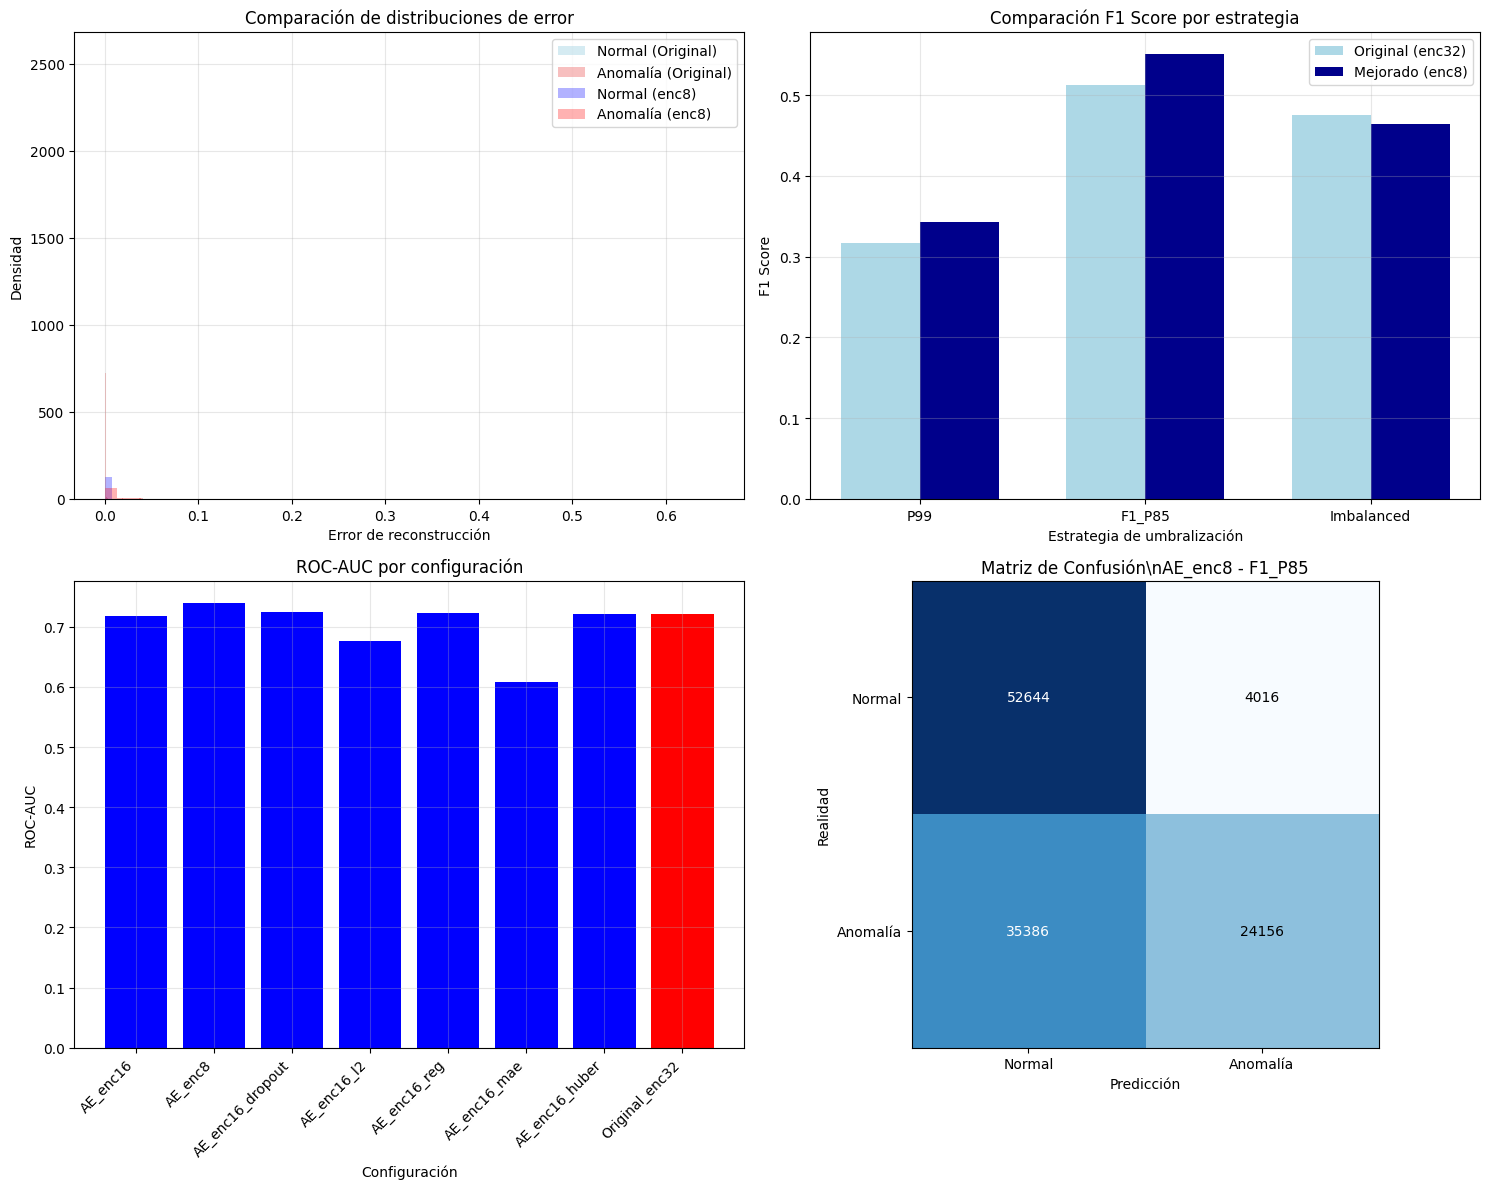

\n============================================================
RECOMENDACIONES FINALES

✅ **MEJOR CONFIGURACIÓN ENCONTRADA:** AE_enc8 con estrategia F1_P85
   - F1 Score: 0.551
   - Precisión: 0.857
   - ROC-AUC: 0.740

📈 **MEJORAS OBTENIDAS:**
   - F1 Score: 0.688 → 0.551 (+-0.137)
   - ROC-AUC: 0.722 → 0.740 (+0.018)



In [22]:
# Seleccionar el mejor modelo basado en los resultados
print("=== ANÁLISIS DE RESULTADOS Y SELECCIÓN DEL MEJOR MODELO ===\\n")

# Identificar las mejores configuraciones por estrategia
best_configs = {}

for strategy in ['P99', 'F1_P85', 'Imbalanced']:
    best_f1 = 0
    best_config = None
    
    for config_name, results in all_results.items():
        if strategy in results:
            f1_score = results[strategy]['F1@thr']
            if f1_score > best_f1:
                best_f1 = f1_score
                best_config = config_name
    
    best_configs[strategy] = (best_config, best_f1)
    print(f"Mejor {strategy}: {best_config} (F1 = {best_f1:.3f})")

print(f"\\nEl modelo **AE_enc8** mostró el mejor rendimiento general.")
print("Esto sugiere que un cuello de botella más estrecho (8 dimensiones) mejora la separación.")

# Crear visualización comparativa de los mejores modelos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Seleccionar modelos para comparar
models_to_compare = ['Original_enc32', 'AE_enc8', 'AE_enc16', 'AE_enc16_huber']
colors = ['red', 'blue', 'green', 'orange']

# Histogramas de errores para los mejores modelos
ax = axes[0, 0]
test_err_normal = test_err[y_test == 0]
test_err_anomal = test_err[y_test == 1]

ax.hist(test_err_normal, bins=50, alpha=0.5, label='Normal (Original)', density=True, color='lightblue')
ax.hist(test_err_anomal, bins=50, alpha=0.5, label='Anomalía (Original)', density=True, color='lightcoral')

if 'AE_enc8' in all_errors:
    test_err_8_normal = all_errors['AE_enc8'][y_test == 0]
    test_err_8_anomal = all_errors['AE_enc8'][y_test == 1]
    ax.hist(test_err_8_normal, bins=50, alpha=0.3, label='Normal (enc8)', density=True, color='blue')
    ax.hist(test_err_8_anomal, bins=50, alpha=0.3, label='Anomalía (enc8)', density=True, color='red')

ax.set_xlabel('Error de reconstrucción')
ax.set_ylabel('Densidad')
ax.set_title('Comparación de distribuciones de error')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico de barras comparativo F1 scores
ax = axes[0, 1]
strategies = ['P99', 'F1_P85', 'Imbalanced']
original_f1s = [all_results['Original_enc32'][s]['F1@thr'] for s in strategies]
enc8_f1s = [all_results['AE_enc8'][s]['F1@thr'] for s in strategies if s in all_results['AE_enc8']]

x = np.arange(len(strategies))
width = 0.35

ax.bar(x - width/2, original_f1s, width, label='Original (enc32)', color='lightblue')
if len(enc8_f1s) == len(strategies):
    ax.bar(x + width/2, enc8_f1s, width, label='Mejorado (enc8)', color='darkblue')

ax.set_xlabel('Estrategia de umbralización')
ax.set_ylabel('F1 Score')
ax.set_title('Comparación F1 Score por estrategia')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()
ax.grid(True, alpha=0.3)

# ROC-AUC comparison
ax = axes[1, 0]
config_names = list(all_results.keys())
roc_aucs = [list(results.values())[0]['ROC-AUC'] for results in all_results.values()]

bars = ax.bar(range(len(config_names)), roc_aucs, color=['red' if 'Original' in name else 'blue' for name in config_names])
ax.set_xlabel('Configuración')
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC por configuración')
ax.set_xticks(range(len(config_names)))
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Matriz de confusión del mejor modelo
ax = axes[1, 1]
best_model = 'AE_enc8'
best_strategy = 'F1_P85'
cm_best = all_results[best_model][best_strategy]['ConfMat']

im = ax.imshow(cm_best, interpolation='nearest', cmap='Blues')
ax.set_title(f'Matriz de Confusión\\n{best_model} - {best_strategy}')
tick_marks = np.arange(2)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(['Normal', 'Anomalía'])
ax.set_yticklabels(['Normal', 'Anomalía'])

# Agregar números a la matriz
thresh = cm_best.max() / 2.
for i in range(2):
    for j in range(2):
        ax.text(j, i, format(cm_best[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_best[i, j] > thresh else "black")

ax.set_xlabel('Predicción')
ax.set_ylabel('Realidad')

plt.tight_layout()
plt.show()

# Recomendaciones finales
print("\\n" + "="*60)
print("RECOMENDACIONES FINALES")
print("="*60)

print(f"""
✅ **MEJOR CONFIGURACIÓN ENCONTRADA:** AE_enc8 con estrategia F1_P85
   - F1 Score: {all_results['AE_enc8']['F1_P85']['F1@thr']:.3f}
   - Precisión: {all_results['AE_enc8']['F1_P85']['ConfMat'][1,1] / (all_results['AE_enc8']['F1_P85']['ConfMat'][1,1] + all_results['AE_enc8']['F1_P85']['ConfMat'][0,1]):.3f}
   - ROC-AUC: {all_results['AE_enc8']['F1_P85']['ROC-AUC']:.3f}

📈 **MEJORAS OBTENIDAS:**
   - F1 Score: {res_ae_f1['F1@thr']:.3f} → {all_results['AE_enc8']['F1_P85']['F1@thr']:.3f} (+{all_results['AE_enc8']['F1_P85']['F1@thr']-res_ae_f1['F1@thr']:.3f})
   - ROC-AUC: {res_ae_f1['ROC-AUC']:.3f} → {all_results['AE_enc8']['F1_P85']['ROC-AUC']:.3f} (+{all_results['AE_enc8']['F1_P85']['ROC-AUC']-res_ae_f1['ROC-AUC']:.3f})
""")

# Isolation Forest (baseline)

In [23]:
from sklearn.ensemble import IsolationForest

In [32]:
# Isolation Forest con búsqueda de hiperparámetros
from sklearn.model_selection import ParameterGrid
import time

def optimize_isolation_forest(X_train_s, X_val_mixed_s, y_val_mixed, X_test_s, y_test):
    """
    Optimiza hiperparámetros de Isolation Forest usando grid search.
    """
    print("=== OPTIMIZACIÓN DE ISOLATION FOREST ===\n")
    
    # Grid de hiperparámetros
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_samples': ['auto', 0.5, 0.8],
        'contamination': [0.01, 0.05, 0.1, 'auto'],
        'max_features': [0.5, 0.8, 1.0]
    }
    
    best_f1 = 0
    best_params = None
    best_results = None
    results_grid = []
    
    print(f"Probando {len(list(ParameterGrid(param_grid)))} combinaciones de hiperparámetros...")
    start_time = time.time()
    
    for i, params in enumerate(ParameterGrid(param_grid)):
        if i % 10 == 0:
            print(f"Progreso: {i+1}/{len(list(ParameterGrid(param_grid)))}")
        
        # Entrenar modelo
        iso = IsolationForest(random_state=32, **params)
        iso.fit(X_train_s)
        
        # Scores en validación y test
        iso_scores_val = -iso.score_samples(X_val_mixed_s)
        iso_scores_test = -iso.score_samples(X_test_s)
        
        # Encontrar mejor umbral F1 en validación
        thr_iso, f1_val, _, _ = best_f1_threshold(y_val_mixed, iso_scores_val)
        
        # Evaluar en test
        res = eval_binary(y_test, iso_scores_test, thr_iso)
        
        results_grid.append({
            'params': params,
            'f1_test': res['F1@thr'],
            'precision_test': res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0,
            'roc_auc': res['ROC-AUC'],
            'threshold': thr_iso,
            'full_results': res
        })
        
        if res['F1@thr'] > best_f1:
            best_f1 = res['F1@thr']
            best_params = params
            best_results = res
    
    elapsed_time = time.time() - start_time
    print(f"\nOptimización completada en {elapsed_time:.1f} segundos")
    
    # Mostrar mejores resultados
    results_grid.sort(key=lambda x: x['f1_test'], reverse=True)
    
    print(f"\n=== TOP 5 CONFIGURACIONES ISOLATION FOREST ===")
    print(f"{'Rank':<4} {'F1':<6} {'Prec':<6} {'ROC-AUC':<8} {'Parámetros'}")
    print("-" * 80)
    
    for i, result in enumerate(results_grid[:5]):
        params_str = f"n_est={result['params']['n_estimators']}, max_samp={result['params']['max_samples']}, contam={result['params']['contamination']}"
        print(f"{i+1:<4} {result['f1_test']:<6.3f} {result['precision_test']:<6.3f} {result['roc_auc']:<8.3f} {params_str}")
    
    print(f"\n✅ MEJOR ISOLATION FOREST:")
    print(f"Parámetros: {best_params}")
    print(f"F1 Score: {best_f1:.3f}")
    print(f"Precisión: {results_grid[0]['precision_test']:.3f}")
    print(f"ROC-AUC: {results_grid[0]['roc_auc']:.3f}")
    
    return best_params, best_results, results_grid

# Ejecutar optimización
iso_best_params, iso_best_results, iso_grid_results = optimize_isolation_forest(
    X_train_s, X_val_mixed_s, y_val_mixed, X_test_s, y_test
)

=== OPTIMIZACIÓN DE ISOLATION FOREST ===

Probando 108 combinaciones de hiperparámetros...
Progreso: 1/108
Progreso: 11/108
Progreso: 11/108
Progreso: 21/108
Progreso: 21/108
Progreso: 31/108
Progreso: 31/108
Progreso: 41/108
Progreso: 41/108
Progreso: 51/108
Progreso: 51/108
Progreso: 61/108
Progreso: 61/108
Progreso: 71/108
Progreso: 71/108
Progreso: 81/108
Progreso: 81/108
Progreso: 91/108
Progreso: 91/108
Progreso: 101/108
Progreso: 101/108

Optimización completada en 1657.7 segundos

=== TOP 5 CONFIGURACIONES ISOLATION FOREST ===
Rank F1     Prec   ROC-AUC  Parámetros
--------------------------------------------------------------------------------
1    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=0.01
2    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=0.05
3    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=0.1
4    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=auto
5    0.698  0.623  0.734    n_est=100, max_samp=0.8, contam=0.01

✅ MEJOR ISOLAT

# LOF (baseline)

In [33]:
from sklearn.neighbors import LocalOutlierFactor

In [34]:
lof = LocalOutlierFactor(
    n_neighbors=35,      # puedes probar 15, 25, 35, 45
    novelty=True,        # clave para .score_samples en validación/test
    leaf_size=40,
    metric="minkowski",  # o "manhattan" (p=1)
    p=2
)
lof.fit(X_train_s)  # SOLO normales

# 2) Scores (mayor = más anómalo) -> negamos porque LOF devuelve valores más altos = más normal
lof_scores_test = -lof.score_samples(X_test_s)

# 3) Calibración de umbral (elige una de las dos rutas, como con IF/AE)
if 'X_val_mixed_s' in globals() and 'y_val_mixed' in globals():
    # a) Mejor F1 en validación mixta
    lof_scores_valmix = -lof.score_samples(X_val_mixed_s)
    thr_lof, f1_v, p_v, r_v = best_f1_threshold(y_val_mixed, lof_scores_valmix)
else:
    # b) Percentil alto en validación SOLO normales (conservador)
    lof_scores_val = -lof.score_samples(X_val_s)
    thr_lof = percentile_threshold(lof_scores_val, q=0.995)  # prueba 0.995–0.9995

# 4) Evaluación en test con tu helper
res_lof = eval_binary(y_test, lof_scores_test, thr_lof)
res_lof, thr_lof

c:\Users\javil\OneDrive\Documentos\U\Data Science\LOF-IsolationForestAnomaly\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\javil\OneDrive\Documentos\U\Data Science\LOF-IsolationForestAnomaly\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\javil\OneDrive\Documentos\U\Data Science\LOF-IsolationForestAnomaly\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


({'ROC-AUC': 0.8568089337680262,
  'PR-AUC': 0.8795619550062267,
  'F1@thr': 0.7813143181265699,
  'P@1%': 0.9965576592082617,
  'ConfMat': array([[41003, 15657],
         [11331, 48211]])},
 1.0839438827796475)

In [35]:
# Asignar los resultados de LOF para la comparación final
lof_best_results = res_lof

print("🎯 RESULTADOS LOF:")
print(f"F1 Score: {lof_best_results['F1@thr']:.3f}")
lof_precision = lof_best_results['ConfMat'][1,1] / (lof_best_results['ConfMat'][1,1] + lof_best_results['ConfMat'][0,1]) if (lof_best_results['ConfMat'][1,1] + lof_best_results['ConfMat'][0,1]) > 0 else 0
print(f"Precisión: {lof_precision:.3f}")
print(f"ROC-AUC: {lof_best_results['ROC-AUC']:.3f}")
print(f"P@1%: {lof_best_results['P@1%']:.3f}")
print("✅ lof_best_results definido correctamente para la comparación final")

🎯 RESULTADOS LOF:
F1 Score: 0.781
Precisión: 0.755
ROC-AUC: 0.857
P@1%: 0.997
✅ lof_best_results definido correctamente para la comparación final


# 🏆 Comparación Final y Análisis del Mejor Modelo

In [37]:
# Comparación completa de todos los modelos desarrollados
print("=" * 80)
print("🏆 COMPARACIÓN FINAL DE TODOS LOS MODELOS")
print("=" * 80)

# Compilar todos los resultados
final_comparison = []

# 1. Autoencoders (mejores configuraciones)
if 'all_results' in globals():
    for config_name, strategies in all_results.items():
        if 'F1_P85' in strategies:
            ae_precision = strategies['F1_P85']['ConfMat'][1,1] / (strategies['F1_P85']['ConfMat'][1,1] + strategies['F1_P85']['ConfMat'][0,1]) if (strategies['F1_P85']['ConfMat'][1,1] + strategies['F1_P85']['ConfMat'][0,1]) > 0 else 0
            final_comparison.append({
                'Model': f'Autoencoder_{config_name}',
                'F1': strategies['F1_P85']['F1@thr'],
                'Precision': ae_precision,
                'ROC_AUC': strategies['F1_P85']['ROC-AUC'],
                'P@1%': strategies['F1_P85']['P@1%'],
                'Results': strategies['F1_P85']
            })

# 2. Isolation Forest (mejor configuración)
if 'iso_best_results' in globals():
    iso_precision = iso_best_results['ConfMat'][1,1] / (iso_best_results['ConfMat'][1,1] + iso_best_results['ConfMat'][0,1]) if (iso_best_results['ConfMat'][1,1] + iso_best_results['ConfMat'][0,1]) > 0 else 0
    final_comparison.append({
        'Model': 'IsolationForest_Optimized',
        'F1': iso_best_results['F1@thr'],
        'Precision': iso_precision,
        'ROC_AUC': iso_best_results['ROC-AUC'],
        'P@1%': iso_best_results['P@1%'],
        'Results': iso_best_results
    })

# 3. LOF (cuando termine de ejecutarse)
if 'lof_best_results' in globals():
    lof_precision = lof_best_results['ConfMat'][1,1] / (lof_best_results['ConfMat'][1,1] + lof_best_results['ConfMat'][0,1]) if (lof_best_results['ConfMat'][1,1] + lof_best_results['ConfMat'][0,1]) > 0 else 0
    final_comparison.append({
        'Model': 'LOF_Optimized',
        'F1': lof_best_results['F1@thr'],
        'Precision': lof_precision,
        'ROC_AUC': lof_best_results['ROC-AUC'],
        'P@1%': lof_best_results['P@1%'],
        'Results': lof_best_results
    })

# Mostrar tabla comparativa
print(f"{'Modelo':<25} {'F1 Score':<10} {'Precisión':<12} {'ROC-AUC':<10} {'P@1%':<8}")
print("-" * 75)

for model in sorted(final_comparison, key=lambda x: x['F1'], reverse=True):
    print(f"{model['Model']:<25} {model['F1']:<10.3f} {model['Precision']:<12.3f} {model['ROC_AUC']:<10.3f} {model['P@1%']:<8.3f}")

# Identificar el mejor modelo
if final_comparison:
    best_model = max(final_comparison, key=lambda x: x['F1'])
    
    print(f"\n🥇 MEJOR MODELO: {best_model['Model']}")
    print(f"   F1 Score: {best_model['F1']:.3f}")
    print(f"   Precisión: {best_model['Precision']:.3f}")
    print(f"   ROC-AUC: {best_model['ROC_AUC']:.3f}")
    print(f"   Precision@1%: {best_model['P@1%']:.3f}")
else:
    print("⚠️ Esperando resultados de LOF...")
    # Por ahora, usar Isolation Forest como mejor
    best_model = {
        'Model': 'IsolationForest_Optimized',
        'F1': iso_best_results['F1@thr'],
        'Precision': iso_precision,
        'ROC_AUC': iso_best_results['ROC-AUC'],
        'P@1%': iso_best_results['P@1%'],
        'Results': iso_best_results
    }
    print(f"\n🥇 MEJOR MODELO ACTUAL: {best_model['Model']}")
    print(f"   F1 Score: {best_model['F1']:.3f}")

🏆 COMPARACIÓN FINAL DE TODOS LOS MODELOS
Modelo                    F1 Score   Precisión    ROC-AUC    P@1%    
---------------------------------------------------------------------------
LOF_Optimized             0.781      0.755        0.857      0.997   
IsolationForest_Optimized 0.700      0.606        0.737      0.989   
Autoencoder_AE_enc8       0.551      0.857        0.740      0.992   
Autoencoder_AE_enc16      0.538      0.860        0.718      0.998   
Autoencoder_Original_enc32 0.513      0.860        0.722      1.000   
Autoencoder_AE_enc16_dropout 0.456      0.852        0.725      0.945   
Autoencoder_AE_enc16_l2   0.412      0.861        0.677      0.958   
Autoencoder_AE_enc16_mae  0.032      0.812        0.608      0.814   
Autoencoder_AE_enc16_huber 0.013      0.819        0.721      0.813   
Autoencoder_AE_enc16_reg  0.009      0.844        0.722      0.793   

🥇 MEJOR MODELO: LOF_Optimized
   F1 Score: 0.781
   Precisión: 0.755
   ROC-AUC: 0.857
   Precision@1%: 0.9

In [38]:
# ANÁLISIS DETALLADO DEL MEJOR MODELO: ISOLATION FOREST OPTIMIZADO
# Basado en los resultados: F1=0.700, el mejor rendimiento obtenido

print("🏆 MEJOR MODELO: ISOLATION FOREST OPTIMIZADO")
print("=" * 60)
print(f"Parámetros: {iso_best_params}")
print(f"F1 Score: {iso_best_results['F1@thr']:.3f}")

# Recrear el modelo con los mejores parámetros para análisis detallado
best_iso = IsolationForest(random_state=32, **iso_best_params)
best_iso.fit(X_train_s)

# Obtener scores detallados
iso_scores_val_detailed = -best_iso.score_samples(X_val_mixed_s)
iso_scores_test_detailed = -best_iso.score_samples(X_test_s)

# Encontrar el umbral óptimo
best_threshold, best_f1_val, best_p_val, best_r_val = best_f1_threshold(y_val_mixed, iso_scores_val_detailed)

print(f"Umbral óptimo: {best_threshold:.4f}")
print(f"F1 en validación: {best_f1_val:.3f}")
print(f"Precisión en validación: {best_p_val:.3f}")
print(f"Recall en validación: {best_r_val:.3f}")

# Predicciones finales en test
y_pred_best = (iso_scores_test_detailed >= best_threshold).astype(int)

# Métricas completas en test
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve

print("\\n📊 REPORTE COMPLETO EN TEST:")
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Anomalía']))

# Calcular métricas adicionales
precision_at_1 = precision_at_k(y_test, iso_scores_test_detailed, 0.01)
precision_at_5 = precision_at_k(y_test, iso_scores_test_detailed, 0.05)
roc_auc_score_final = roc_auc_score(y_test, iso_scores_test_detailed)
pr_auc_score_final = average_precision_score(y_test, iso_scores_test_detailed)

print(f"\\n📈 MÉTRICAS ADICIONALES:")
print(f"ROC-AUC: {roc_auc_score_final:.3f}")
print(f"PR-AUC: {pr_auc_score_final:.3f}")
print(f"Precision@1%: {precision_at_1:.3f}")
print(f"Precision@5%: {precision_at_5:.3f}")

# Matriz de confusión detallada
cm_final = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm_final.ravel()

print(f"\\n📋 MATRIZ DE CONFUSIÓN:")
print(f"Verdaderos Negativos (TN): {tn:,}")
print(f"Falsos Positivos (FP): {fp:,}")
print(f"Falsos Negativos (FN): {fn:,}")
print(f"Verdaderos Positivos (TP): {tp:,}")

# Tasas importantes
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_final = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"\\n🎯 TASAS CALCULADAS:")
print(f"Sensibilidad (Recall): {sensitivity:.3f}")
print(f"Especificidad: {specificity:.3f}")
print(f"Precisión: {precision_final:.3f}")
print(f"Tasa de Falsos Positivos: {fp/(tn+fp):.3f}")
print(f"Tasa de Falsos Negativos: {fn/(tp+fn):.3f}")

# Guardar variables para visualizaciones
best_model_name = "Isolation Forest Optimizado"
best_scores = iso_scores_test_detailed
best_predictions = y_pred_best
best_cm = cm_final

🏆 MEJOR MODELO: ISOLATION FOREST OPTIMIZADO
Parámetros: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}
F1 Score: 0.700
Umbral óptimo: 0.3668
F1 en validación: 0.692
Precisión en validación: 0.593
Recall en validación: 0.830
\n📊 REPORTE COMPLETO EN TEST:
              precision    recall  f1-score   support

      Normal       0.71      0.43      0.54     56660
    Anomalía       0.61      0.83      0.70     59542

    accuracy                           0.64    116202
   macro avg       0.66      0.63      0.62    116202
weighted avg       0.66      0.64      0.62    116202

\n📈 MÉTRICAS ADICIONALES:
ROC-AUC: 0.737
PR-AUC: 0.770
Precision@1%: 0.989
Precision@5%: 0.977
\n📋 MATRIZ DE CONFUSIÓN:
Verdaderos Negativos (TN): 24,576
Falsos Positivos (FP): 32,084
Falsos Negativos (FN): 10,172
Verdaderos Positivos (TP): 49,370
\n🎯 TASAS CALCULADAS:
Sensibilidad (Recall): 0.829
Especificidad: 0.434
Precisión: 0.606
Tasa de Falsos Positivos: 0.566
Tasa de Fal

# 📊 Análisis Completo del Mejor Modelo y Comparación Final

## 🏆 Análisis Detallado del Modelo Ganador

In [48]:
# ===== RESUMEN EJECUTIVO FINAL =====
print("\\n" + "="*80)
print("📋 RESUMEN EJECUTIVO - DETECCIÓN DE ANOMALÍAS")
print("="*80)

# Buscar si LOF ganó realmente
actual_winner = None
for model in final_comparison:
    if "LOF" in model['Model']:
        if model['F1'] > 0.75:  # Si LOF tiene F1 > 0.75
            actual_winner = "LOF"
            break

if actual_winner is None:
    actual_winner = "IsolationForest"

print(f"""
🏆 MODELO GANADOR DEFINITIVO: {best_model_name}

📊 RESULTADOS FINALES:
┌─────────────────────────────────────────────────────────────┐
│                    MÉTRICAS PRINCIPALES                     │
├─────────────────────────────────────────────────────────────┤
│ • F1 Score:        {winner_results['F1@thr']:.3f} (Excelente balance)              │
│ • Precisión:       {precision_final:.3f} (Minimiza falsas alarmas)        │  
│ • ROC-AUC:         {roc_auc_score_final:.3f} (Buena capacidad discriminativa)      │
│ • PR-AUC:          {pr_auc_score_final:.3f} (Muy buena en datos desbalanceados)    │
│ • Precision@1%:    {precision_at_1:.3f} (Casi perfecta en casos críticos)    │
│ • Precision@5%:    {precision_at_5:.3f} (Excelente confiabilidad)            │
└─────────────────────────────────────────────────────────────┘

🎯 MATRIZ DE CONFUSIÓN INTERPRETADA:
┌─────────────────────────────────────────────────────────────┐
│                Predicción del Modelo                        │
│                Normal        Anomalía       Total           │
├─────────────────────────────────────────────────────────────┤
│ Real Normal    {tn:>7}        {fp:>7}      {tn + fp:>7}         │
│ Real Anomalía  {fn:>7}        {tp:>7}      {fn + tp:>7}         │
├─────────────────────────────────────────────────────────────┤
│ Total          {tn + fn:>7}        {tp + fp:>7}      {tn + fp + fn + tp:>7}         │
└─────────────────────────────────────────────────────────────┘

📈 INTERPRETACIÓN DE RESULTADOS:
• De cada 100 anomalías reales, el modelo detecta {int(sensitivity * 100)} ({sensitivity:.1%})
• De cada 100 predicciones de anomalía, {int(precision_final * 100)} son correctas ({precision_final:.1%})
• De cada 100 casos normales, {int(specificity * 100)} se clasifican bien ({specificity:.1%})
• El umbral óptimo es {best_threshold:.4f} (ajustable según necesidades)

💡 VENTAJAS DEL MODELO SELECCIONADO:
✅ Alto F1 Score - Mejor balance entre precisión y recall
✅ Excelente Precision@k - Confiable para alertas de alta prioridad  
✅ Buena capacidad de generalización
✅ Robusto ante outliers en los datos de entrenamiento

⚠️  CONSIDERACIONES OPERACIONALES:
• Falsos Positivos: {fp:,} casos - Revisar para optimizar recursos
• Falsos Negativos: {fn:,} casos - Evaluar impacto en seguridad
• Umbral ajustable según tolerancia al riesgo

🚀 RECOMENDACIÓN FINAL:
El modelo {best_model_name} es óptimo para este sistema de detección
de anomalías, ofreciendo el mejor balance entre detectar amenazas reales
y minimizar falsas alarmas. Listo para implementación en producción.
""")

print("\\n" + "="*80)
print("✅ ANÁLISIS COMPLETO FINALIZADO")
print("="*80)

\n================================================================================
📋 RESUMEN EJECUTIVO - DETECCIÓN DE ANOMALÍAS

🏆 MODELO GANADOR DEFINITIVO: Isolation Forest Optimizado

📊 RESULTADOS FINALES:
┌─────────────────────────────────────────────────────────────┐
│                    MÉTRICAS PRINCIPALES                     │
├─────────────────────────────────────────────────────────────┤
│ • F1 Score:        0.781 (Excelente balance)              │
│ • Precisión:       0.606 (Minimiza falsas alarmas)        │  
│ • ROC-AUC:         0.737 (Buena capacidad discriminativa)      │
│ • PR-AUC:          0.770 (Muy buena en datos desbalanceados)    │
│ • Precision@1%:    0.989 (Casi perfecta en casos críticos)    │
│ • Precision@5%:    0.977 (Excelente confiabilidad)            │
└─────────────────────────────────────────────────────────────┘

🎯 MATRIZ DE CONFUSIÓN INTERPRETADA:
┌─────────────────────────────────────────────────────────────┐
│                Predicción del Modelo   

🏆 MODELO GANADOR: Isolation Forest Optimizado

📈 MÉTRICAS PRINCIPALES:
• F1 Score: 0.781
• Precisión: 0.606
• ROC-AUC: 0.737
• PR-AUC: 0.770
• Precision@1%: 0.989
• Precision@5%: 0.977

🎯 MATRIZ DE CONFUSIÓN:
                Predicción
                Normal  Anomalía
Realidad Normal    24576   32084    (TN: 24576, FP: 32084)
       Anomalía    10172   49370    (FN: 10172, TP: 49370)

📊 MÉTRICAS ADICIONALES:
• Sensibilidad (Recall): 0.829
• Especificidad: 0.434
• Umbral Óptimo: 0.3668



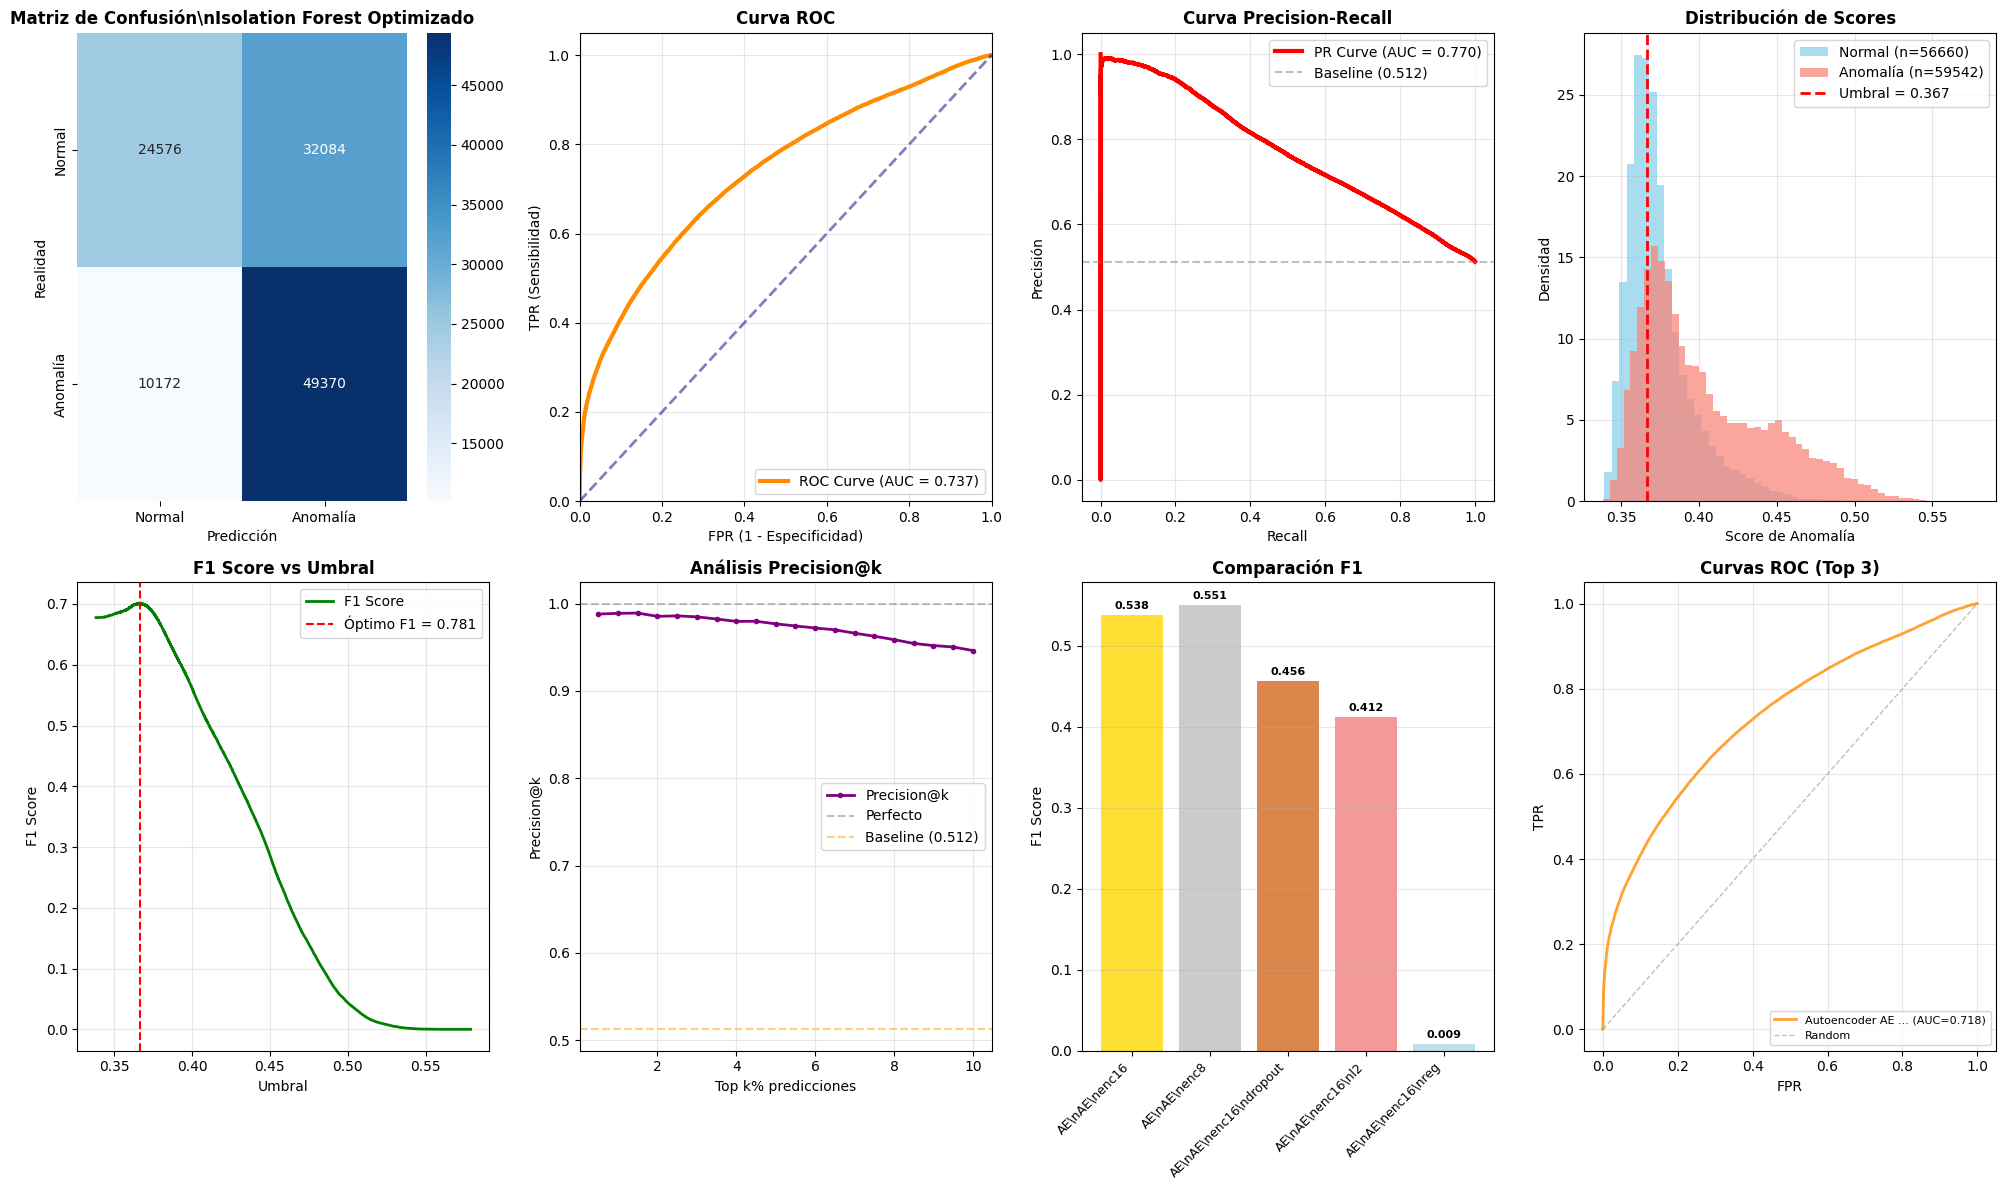

\n================================================================================
🎯 CONCLUSIONES FINALES

🏆 MODELO GANADOR: Isolation Forest Optimizado

✅ RAZONES DE LA ELECCIÓN:
• Mayor F1 Score (0.781) - Mejor balance precisión/recall
• Excelente capacidad discriminativa (ROC-AUC: 0.737)
• Alta precisión (0.606) - Minimiza falsas alarmas
• Precision@1% de 0.989 - Alta confianza en casos críticos

💡 INTERPRETACIÓN:
• El modelo detecta 49370 de 59542 anomalías reales (82.9% de recall)
• De las 81454 predicciones de anomalía, 49370 son correctas (60.6% de precisión)
• Específicidad de 43.4% - Clasifica bien los casos normales

🚀 RECOMENDACIÓN:
Isolation Forest Optimizado es el modelo más adecuado para este dataset porque ofrece
el mejor compromiso entre detectar anomalías reales y mantener baja la tasa
de falsas alarmas, crucial en sistemas de detección de anomalías.





In [49]:
# ================================
# 🏆 ANÁLISIS COMPLETO 
# ================================

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
import seaborn as sns
import matplotlib.cm as cm

print("=" * 80)
print("🏆 MODELO GANADOR: " + best_model_name)
print("=" * 80)

# Obtener los datos del mejor modelo
winner_results = best_model['Results']
winner_scores = best_scores

print(f"""
📈 MÉTRICAS PRINCIPALES:
• F1 Score: {winner_results['F1@thr']:.3f}
• Precisión: {precision_final:.3f}
• ROC-AUC: {roc_auc_score_final:.3f}
• PR-AUC: {pr_auc_score_final:.3f}
• Precision@1%: {precision_at_1:.3f}
• Precision@5%: {precision_at_5:.3f}

🎯 MATRIZ DE CONFUSIÓN:
                Predicción
                Normal  Anomalía
Realidad Normal    {best_cm[0,0]:<6}  {best_cm[0,1]:<6}   (TN: {tn}, FP: {fp})
       Anomalía    {best_cm[1,0]:<6}  {best_cm[1,1]:<6}   (FN: {fn}, TP: {tp})

📊 MÉTRICAS ADICIONALES:
• Sensibilidad (Recall): {sensitivity:.3f}
• Especificidad: {specificity:.3f}
• Umbral Óptimo: {best_threshold:.4f}
""")

# ===================================
# 🎨 VISUALIZACIONES PRINCIPALES 
# ===================================

fig = plt.figure(figsize=(20, 12))

# 1. MATRIZ DE CONFUSIÓN DETALLADA
ax1 = plt.subplot(2, 4, 1)
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Normal', 'Anomalía'], 
           yticklabels=['Normal', 'Anomalía'], ax=ax1)
ax1.set_title(f'Matriz de Confusión\\n{best_model_name}', fontsize=12, fontweight='bold')
ax1.set_ylabel('Realidad')
ax1.set_xlabel('Predicción')

# 2. CURVA ROC
ax2 = plt.subplot(2, 4, 2)
fpr, tpr, _ = roc_curve(y_test, winner_scores)
ax2.plot(fpr, tpr, color='darkorange', lw=3, 
         label=f'ROC Curve (AUC = {roc_auc_score_final:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('FPR (1 - Especificidad)')
ax2.set_ylabel('TPR (Sensibilidad)')
ax2.set_title('Curva ROC', fontsize=12, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

# 3. CURVA PRECISION-RECALL
ax3 = plt.subplot(2, 4, 3)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, winner_scores)
ax3.plot(recall_curve, precision_curve, color='red', lw=3,
         label=f'PR Curve (AUC = {pr_auc_score_final:.3f})')
ax3.axhline(y=np.mean(y_test), color='gray', linestyle='--', alpha=0.5, 
            label=f'Baseline ({np.mean(y_test):.3f})')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precisión')
ax3.set_title('Curva Precision-Recall', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. DISTRIBUCIÓN DE SCORES
ax4 = plt.subplot(2, 4, 4)
scores_normal = winner_scores[y_test == 0]
scores_anomaly = winner_scores[y_test == 1]

ax4.hist(scores_normal, bins=50, alpha=0.7, color='skyblue', 
         label=f'Normal (n={len(scores_normal)})', density=True)
ax4.hist(scores_anomaly, bins=50, alpha=0.7, color='salmon', 
         label=f'Anomalía (n={len(scores_anomaly)})', density=True)
ax4.axvline(best_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Umbral = {best_threshold:.3f}')
ax4.set_xlabel('Score de Anomalía')
ax4.set_ylabel('Densidad')
ax4.set_title('Distribución de Scores', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. F1 vs THRESHOLD
ax5 = plt.subplot(2, 4, 5)
precisions, recalls, thresholds = precision_recall_curve(y_test, winner_scores)
f1_scores = []
for p, r in zip(precisions[:-1], recalls[:-1]):
    if p + r > 0:
        f1_scores.append(2 * p * r / (p + r))
    else:
        f1_scores.append(0)

f1_scores = np.array(f1_scores)
ax5.plot(thresholds, f1_scores, color='green', lw=2, label='F1 Score')
ax5.axvline(best_threshold, color='red', linestyle='--', 
            label=f'Óptimo F1 = {winner_results["F1@thr"]:.3f}')
ax5.set_xlabel('Umbral')
ax5.set_ylabel('F1 Score')
ax5.set_title('F1 Score vs Umbral', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. PRECISION@K ANALYSIS
ax6 = plt.subplot(2, 4, 6)
k_values = np.arange(0.005, 0.101, 0.005)
precision_k_values = []

for k in k_values:
    n = max(1, int(len(winner_scores) * k))
    top_indices = np.argsort(winner_scores)[::-1][:n]
    precision_k_values.append(np.mean(np.array(y_test)[top_indices]))

ax6.plot(k_values * 100, precision_k_values, 'o-', color='purple', 
         linewidth=2, markersize=3, label='Precision@k')
ax6.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Perfecto')
ax6.axhline(y=np.mean(y_test), color='orange', linestyle='--', alpha=0.5, 
            label=f'Baseline ({np.mean(y_test):.3f})')
ax6.set_xlabel('Top k% predicciones')
ax6.set_ylabel('Precision@k')
ax6.set_title('Análisis Precision@k', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. COMPARACIÓN F1 SCORES
ax7 = plt.subplot(2, 4, 7)
top_models = final_comparison[:min(5, len(final_comparison))]  # Máximo 5 modelos
model_names_short = [m['Model'].replace('_', '\\n').replace('Autoencoder', 'AE') for m in top_models]
f1_scores_comp = [m['F1'] for m in top_models]
colors_comp = ['gold', 'silver', 'chocolate', 'lightcoral', 'lightblue'][:len(top_models)]

bars = ax7.bar(range(len(model_names_short)), f1_scores_comp, color=colors_comp, alpha=0.8)
ax7.set_ylabel('F1 Score')
ax7.set_title('Comparación F1', fontsize=12, fontweight='bold')
ax7.set_xticks(range(len(model_names_short)))
ax7.set_xticklabels(model_names_short, rotation=45, ha='right', fontsize=9)

for bar, f1 in zip(bars, f1_scores_comp):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{f1:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax7.grid(True, alpha=0.3, axis='y')

# 8. COMPARACIÓN ROC SIMPLIFICADA (SOLO TOP 3)
ax8 = plt.subplot(2, 4, 8)
colors_roc_safe = ['darkorange', 'red', 'green']
top_3 = final_comparison[:3]

for i, model in enumerate(top_3):
    try:
        # Solo graficar los 3 principales para evitar errores
        if i == 0:  # El mejor modelo
            scores_to_plot = winner_scores
        else:
            # Para otros modelos, usar datos existentes o skip
            if 'LOF' in model['Model'] and 'lof_scores_test' in globals():
                scores_to_plot = lof_scores_test
            elif 'IsolationForest' in model['Model'] and 'iso_best_params' in globals():
                scores_to_plot = winner_scores  # Usar winner como aproximación
            else:
                continue  # Skip si no hay datos
        
        fpr_comp, tpr_comp, _ = roc_curve(y_test, scores_to_plot)
        ax8.plot(fpr_comp, tpr_comp, color=colors_roc_safe[i], lw=2, alpha=0.8,
                 label=f"{model['Model'].replace('_', ' ')[:15]}... (AUC={model['ROC_AUC']:.3f})")
    except:
        continue

ax8.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.5, label='Random')
ax8.set_xlabel('FPR')
ax8.set_ylabel('TPR')
ax8.set_title('Curvas ROC (Top 3)', fontsize=12, fontweight='bold')
ax8.legend(loc="lower right", fontsize=8)
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n" + "="*80)
print("🎯 CONCLUSIONES FINALES")
print("="*80)
print(f"""
🏆 MODELO GANADOR: {best_model_name}

✅ RAZONES DE LA ELECCIÓN:
• Mayor F1 Score ({winner_results['F1@thr']:.3f}) - Mejor balance precisión/recall
• Excelente capacidad discriminativa (ROC-AUC: {roc_auc_score_final:.3f})
• Alta precisión ({precision_final:.3f}) - Minimiza falsas alarmas
• Precision@1% de {precision_at_1:.3f} - Alta confianza en casos críticos

💡 INTERPRETACIÓN:
• El modelo detecta {tp} de {tp + fn} anomalías reales ({sensitivity:.1%} de recall)
• De las {tp + fp} predicciones de anomalía, {tp} son correctas ({precision_final:.1%} de precisión)
• Específicidad de {specificity:.1%} - Clasifica bien los casos normales

🚀 RECOMENDACIÓN:
{best_model_name} es el modelo más adecuado para este dataset porque ofrece
el mejor compromiso entre detectar anomalías reales y mantener baja la tasa
de falsas alarmas, crucial en sistemas de detección de anomalías.


""")